In [1]:
import pandas as pd
import numpy as np
import math as mt
import matplotlib.pyplot as plt
from scipy.stats import *
import geopandas as gpd

In [2]:
path=''
france = gpd.read_file(path+"departements.geojson")
world = gpd.read_file(path+"countries.geojson")

In [3]:
data_communes = pd.read_csv(path+'RGC_2013.csv',sep=';', dtype=str)
data_emplois=pd.read_csv(path+'Emplois_salaries.csv',sep=';', dtype=str)

#Traitement préalable des données à effectuer
data_communes.DEP.astype(str)
data_communes.COM.astype(str)
data_emplois.astype(str)
data_communes.insert(loc=2, column="COG", value=data_communes.DEP+data_communes.COM.str.zfill(3))

print(data_communes)
print(data_emplois)

      DEP  COM    COG ARRD CANT ADMI POPU SURFACE          NOM XLAMB2  ...  \
0       1  445   1445    2   11    6    6    1386  VILLEMOTIER   8297  ...   
1       1   98   1098    1    4    6    7    1059  CHAZEY-BONS   8600  ...   
2       1   57   1057    2   26    6    5     731          BOZ   7978  ...   
3       1  149   1149    1    1    6   10     526      DOUVRES   8352  ...   
4       1  436   1436    3   14    6    5    1070      VESANCY   8888  ...   
...    ..  ...    ...  ...  ...  ...  ...     ...          ...    ...  ...   
36547  2B   58  2B058    2    9    6    3    1667       CANARI  11722  ...   
36548  2B   43  2B043    2    9    5   16    2222       BRANDO  11848  ...   
36549  2B  178  2B178    2    9    6    1     804        NONZA  11740  ...   
36550  2B   33  2B033    2   99    3  430    1938       BASTIA  11834  ...   
36551  2B   29  2B029    5   29    6    2    1086    BARBAGGIO  11776  ...   

      XLAMBZ YLAMBZ XLAMB93 YLAMB93 LONGI_GRD LATI_GRD LONGI_DM

In [4]:
def associate_arr_mun(num_dep,cog,num_arr_debut,num_arr_fin):
    list_arr_com=[str(num_dep)+str(num_arr).zfill(3) for num_arr in \
                  range(num_arr_debut,num_arr_fin+1)]
    mask=data_emplois['CODGEO'].str.zfill(5).isin(list_arr_com)
    data_emplois_commune=data_emplois[mask].sum()
    data_emplois_commune['CODGEO']=str(cog)
    data_emplois.loc[len(data_emplois)]=data_emplois_commune.values

In [5]:
associate_arr_mun(75,75056,101,120)
associate_arr_mun(13,13055,201,216)
associate_arr_mun(69,69123,381,389)

         COG POPU EFF_TOT SURFACE      RATIO         DENS
0       1445    6      31    1386   5.166667    43.290043
1       1098    7     401    1059  57.285714    66.100094
2       1057    5      69     731  13.800000    68.399453
3       1149   10      24     526   2.400000   190.114068
4       1436    5      13    1070   2.600000    46.728972
...      ...  ...     ...     ...        ...          ...
34818  2B058    3      27    1667   9.000000    17.996401
34819  2B043   16     215    2222  13.437500    72.007201
34820  2B178    1      13     804  13.000000    12.437811
34821  2B033  430   17980    1938  41.813953  2218.782250
34822  2B029    2      19    1086   9.500000    18.416206

[34752 rows x 6 columns]


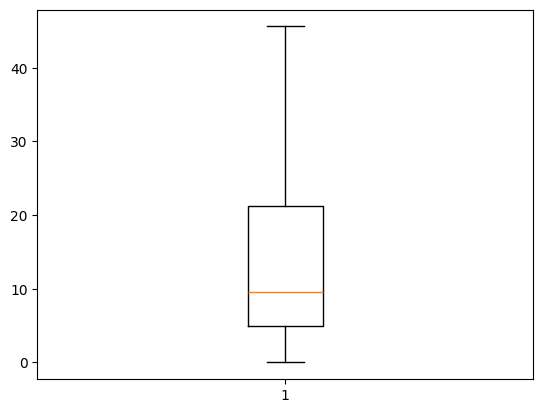

In [6]:
#Question 3.2
temp_commune = data_communes[data_communes['POPU']!= 0][['COG', 'POPU', 'SURFACE']]
temp_emplois = data_emplois[['CODGEO','EFF_TOT']]
ratio = pd.merge(left=temp_commune, right=temp_emplois, how='inner', left_on=['COG'], right_on=['CODGEO'])[['COG', 'POPU', 'EFF_TOT', 'SURFACE']]
ratio.insert(loc=len(ratio.columns), column="RATIO", value=ratio.EFF_TOT.astype(float)/ratio.POPU.astype(float))
ratio.insert(loc=len(ratio.columns), column='DENS', value=(ratio.POPU.astype(float)*100)/(ratio.SURFACE.astype(float)/100))
ratio.dropna(inplace=True)
print(ratio)
plt.boxplot(x=ratio['RATIO'], showmeans=True, meanline=True, showfliers=False)
plt.show()

Expliquer ici la différence entre moyenne et médiane. Par ailleurs quel indicateur statistique pourrait-on utiliser pour quantifier la dispersion des données ?

In [7]:
#Question 3.3
print(ratio.RATIO.mean(), ratio.RATIO.median(), ratio.RATIO.std())

inf 9.5 nan


C:\Users\sacha_8crotws\AppData\Roaming\Python\Python311\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [8]:
#calculs à effectuer pour rajouter la densité de population (DENS) par département
# * DENS (Hab/Km²) = (POPU*100)/(SURFACE/100)
print(ratio.DENS)

0          43.290043
1          66.100094
2          68.399453
3         190.114068
4          46.728972
            ...     
34818      17.996401
34819      72.007201
34820      12.437811
34821    2218.782250
34822      18.416206
Name: DENS, Length: 34752, dtype: float64


type dataframe jointure :  <class 'pandas.core.frame.DataFrame'>


KeyError: 'DENS'

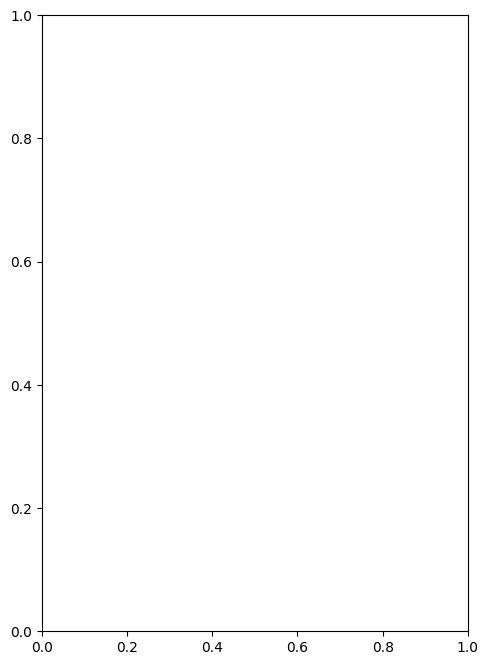

In [9]:
#Carte densité par départements
#jointure à effectuer
# france_map = pd.merge(left=data_communes,right=france,how='inner',left_on=data_communes['DEP'].str.zfill(2), right_on='code')
france_map = None

print('type dataframe jointure : ',type(france_map))
france_map = gpd.GeoDataFrame(france_map)
fig, ax = plt.subplots(1, figsize=(9,8))
# On crée 5 catégories en utilisant des quantiles (la notion de quantiles est un terme générique, avec 4 catégories on subdivise les quantiles sont des quartiles et avec 10 catégories les quantiles sont des déciles)
france_map.plot(ax=ax, 
                column='DENS', 
                cmap='GnBu', #https://matplotlib.org/stable/tutorials/colors/colormaps.html  YlOrRd
                scheme='quantiles', 
                k=5, 
                legend=True,legend_kwds={'loc':'center left','bbox_to_anchor':(-0.1, 0.5)})

ax.axis('off')
plt.title("Densité population par département", fontsize=15)
ax.annotate('Année: 2013', xy=(0.1, .15), 
                                   xycoords='figure fraction', 
                                   horizontalalignment='left', 
                                   verticalalignment='top', 
                                   fontsize=12, 
                                   color='#555555')
plt.show()

Interpréter précisément ici la signification des données représentées sur les départements avec la teinte la plus claire

In [ ]:
#Cartes avec qqs communes

fig, ax = plt.subplots(1, figsize=(10,10))
world_map = gpd.GeoDataFrame(world)
world_map.plot(ax=ax)
ax.set_xlim(-5, 10)
ax.set_ylim(42, 52)
